### SIRSDE example

In [1]:
from functools import partial
from flowjax.train import fit_to_key_based_loss
from spyrox.train import ProgramToProgramSamplesLoss
from pyrox.program import SetKwargs
from pyrox.program import GuideToDataSpace

import jax
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from functools import partial
import jax.numpy as jnp
from spyrox.train import rounds_based_snle# , continuous_training
from spyrox.tasks.sirsde import SIRSDEGuide, SIRSDEModel
import equinox as eqx
from spyrox.plot_utils import pairplot_dictionary
from pyrox.losses import SoftContrastiveEstimationLoss,EvidenceLowerBoundLoss
from spyrox.tasks.sirsde import get_task

### Define the model

In [2]:
key, subkey = jr.split(jr.key(1))
model, guide  = get_task(subkey)

### Generate toy data

In [3]:
# simulated obs
key, subkey = jr.split(key)
true_latents = eqx.filter_jit(model.sample)(subkey, use_surrogate=False)
[print(k, v.shape) for k, v in true_latents.items()]
obs = true_latents.pop("x")

infection_rate (2,)
infection_rate_base (2,)
infection_rate_mean ()
infection_rate_mean_base ()
r0_mean_reversion (2,)
r0_mean_reversion_base (2,)
r0_mean_reversion_mean ()
r0_mean_reversion_mean_base ()
r0_volatility (2,)
r0_volatility_base (2,)
r0_volatility_mean ()
r0_volatility_mean_base ()
recovery_rate (2,)
recovery_rate_base (2,)
recovery_rate_mean ()
recovery_rate_mean_base ()
x (2, 3)
z (2, 4)


### Fit posterior

In [4]:
def prior_entropy(key, prior, n: int = 1000):

    def _single(key):
        return prior.sample_and_log_prob(key)[1]
    
    return -jax.vmap(_single)(jr.split(key, n)).mean()


In [5]:
# Prefit to prior
key, subkey = jr.split(key)
prior = SetKwargs(model.get_prior(observed_sites=("x",)), use_surrogate=False)

In [6]:
key2, subkey = jr.split(key)
prior_entropy(key2, prior)

Array(16.95917, dtype=float32)

In [21]:
key, subkey = jr.split(key)
from pyrox.losses import SoftContrastiveEstimationLoss

surrogate_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(8e-4), max_consecutive_errors=10),
    "max_epochs": 200,
    "max_patience": 3,
    "batch_size": 40,
}

guide_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(1e-2), max_consecutive_errors=10),
    "loss_fn": SoftContrastiveEstimationLoss(n_particles=2, alpha=0.8),
    "steps": 5000,
}


(model, guide), losses =  rounds_based_snle(
    key=subkey,
    model=model,
    guide=guide,
    num_rounds=3,
    sim_per_round=2000, # n_obs*sim_per_round
    sim_param_name="z",
    surrogate_fit_kwargs=surrogate_fit_kwargs,
    guide_fit_kwargs=guide_fit_kwargs,
    obs=obs,
)


100%|██████████| 5000/5000 [01:35<00:00, 52.11it/s, loss=0.78]  


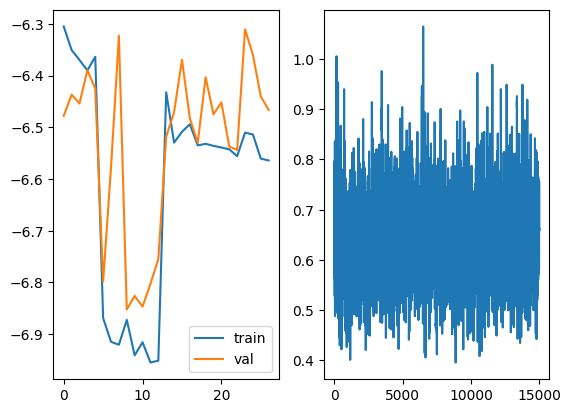

In [22]:
fig, axes = plt.subplots(ncols=2)

for k, loss_vals_round in losses["surrogate"].items():
    vals = [l for loss_vals in loss_vals_round for l in loss_vals]
    axes[0].plot(vals, label=k)
axes[0].legend()
axes[1].plot(
    jnp.convolve(jnp.asarray(losses["guide"]).ravel(), 0.1*jnp.ones(10), mode="valid"),
)


In [24]:
key, subkey = jr.split(key)
n_samples = 1000

key, subkey = jr.split(key)
joint_samples = jax.jit(jax.vmap(partial(model.sample, use_surrogate=False)))(
    jr.split(key, n_samples),
    )

guide_data_space = GuideToDataSpace(
    guide=guide,
    model=model,
    guide_kwargs={"obs": obs},
    model_kwargs={"obs": obs, "use_surrogate": True},
    )

posterior_samps = jax.jit(jax.vmap(guide_data_space.sample))(jr.split(key, n_samples))


### Local inference

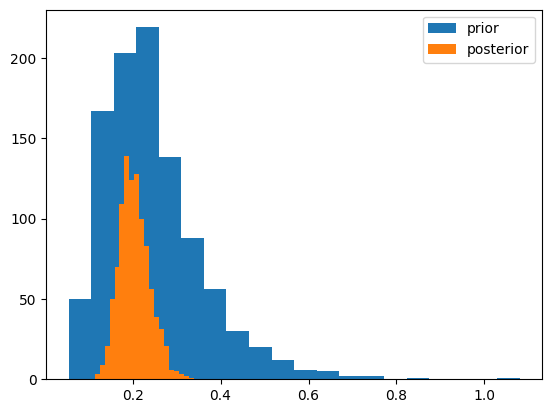

In [27]:
obs_idx=
plt.hist(joint_samples["recovery_rate"][:n_samples, 0], label="prior", bins=20)
plt.hist(posterior_samps["recovery_rate"][:n_samples, 0], label="posterior", bins=20)
plt.legend()

(array([ 16., 104., 176., 197., 178., 115.,  75.,  47.,  32.,  23.,  15.,
          7.,   2.,   3.,   2.,   1.,   3.,   1.,   2.,   1.]),
 array([0.03455798, 0.08152756, 0.12849714, 0.17546672, 0.22243629,
        0.26940587, 0.31637543, 0.363345  , 0.41031459, 0.45728418,
        0.50425375, 0.55122334, 0.59819293, 0.64516252, 0.69213206,
        0.73910165, 0.78607124, 0.83304083, 0.88001043, 0.92697996,
        0.97394955]),
 <BarContainer object of 20 artists>)

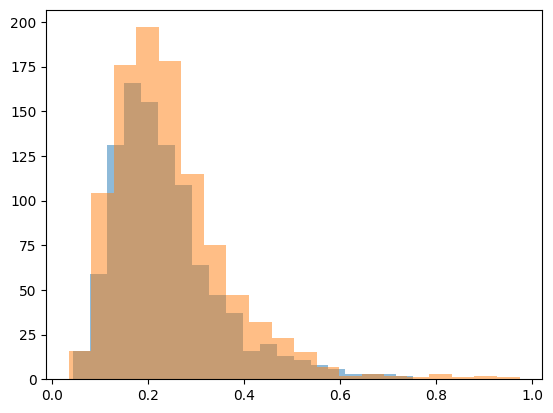

In [11]:
obs_idx = 1

plt.hist(posterior_samps["infection_rate"][:, obs_idx], alpha=0.5, bins=20)
plt.hist(joint_samples["infection_rate"][:, obs_idx], alpha=0.5, bins=20)



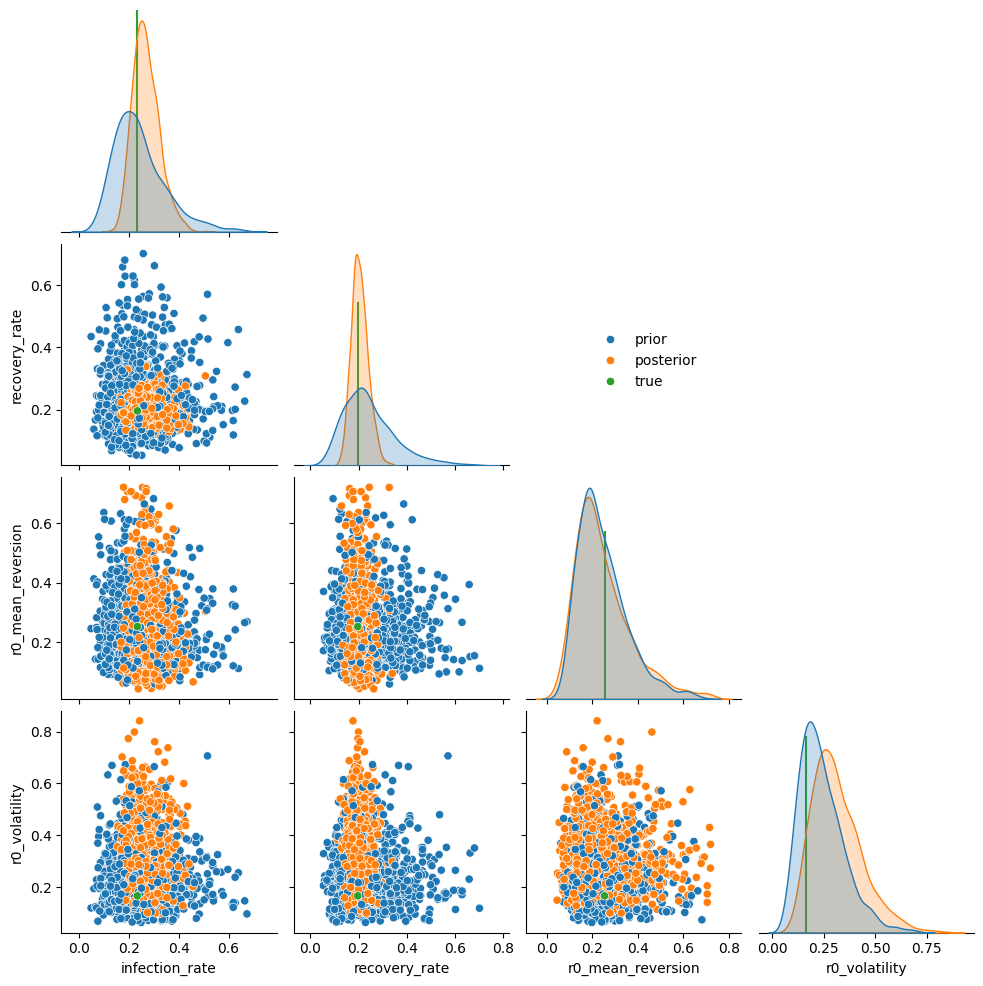

In [34]:
obs_idx = 0
local_params = ["infection_rate", "recovery_rate", "r0_mean_reversion", "r0_volatility"]

datasets = {
    "prior": jnp.stack([joint_samples[k][:, obs_idx] for k in local_params], axis=-1),
    "posterior":  jnp.stack([posterior_samps[k][:, obs_idx] for k in local_params], axis=-1),
    "true": jnp.stack([true_latents[k][obs_idx] for k in local_params]),
}

pairplot_dictionary(
    datasets, column_names=local_params,
)


## Global inference

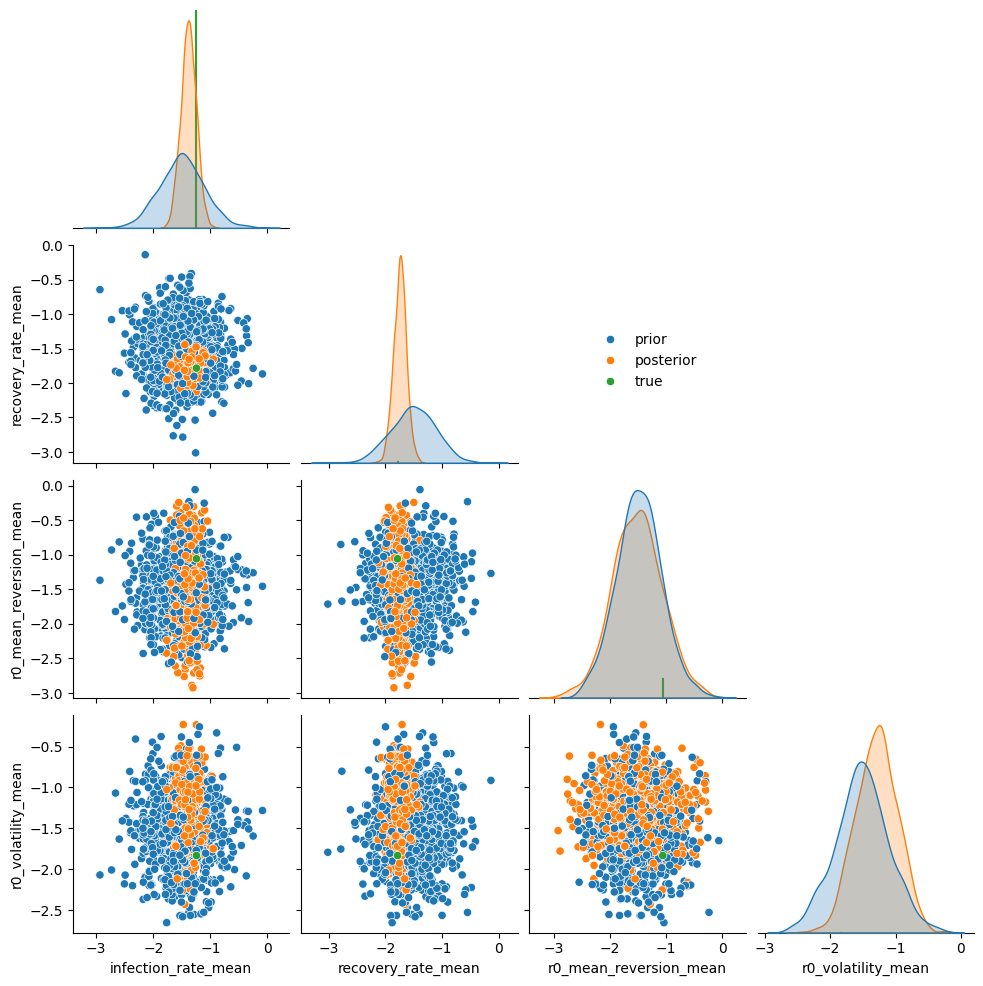

In [35]:
global_params = [
    "infection_rate_mean",
    "recovery_rate_mean",
    "r0_mean_reversion_mean",
    "r0_volatility_mean",
    ]

datasets = {
    "prior": jnp.stack([joint_samples[k] for k in global_params], axis=-1),
    "posterior": jnp.stack([posterior_samps[k] for k in global_params], axis=-1),
    "true": jnp.stack([true_latents[k] for k in global_params]),
}

pairplot_dictionary(
    datasets, column_names=global_params,

)


### Plot the traces

In [18]:
import equinox as eqx
key, subkey = jr.split(key)

posterior_predictive = eqx.filter_vmap(SetKwargs(model, use_surrogate=False).sample)(
    jr.split(key, n_samples), posterior,
)["x"]




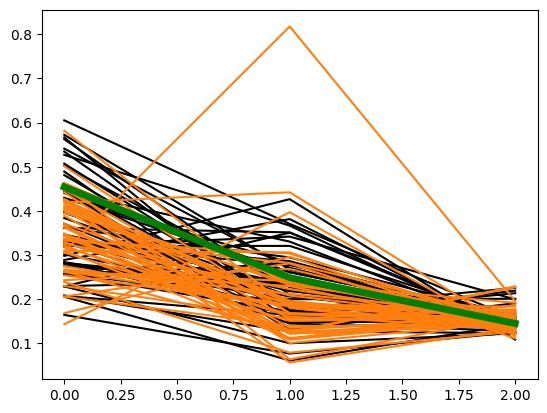

In [19]:
obs_idx = 4
plt.plot(joint_samples["x"][:50, obs_idx].T, color="black")
plt.plot(posterior_predictive[:50, obs_idx].T, color="tab:orange")
plt.plot(obs[obs_idx], color="green", linewidth=5)

